# Ex2 - Solution

## Q1

### Objective
In this question, you will implement the power method to estimate the dominant right singular
vector of a matrix $A∈R^{n×m}$, where $n>m$. You will explore how the choice of initialization affects
convergence and visualize the error across iterations. Your implementation will be compared against
the true singular vectors obtained from the SVD.

### (A) Generating a Matrix with a Singular Value Gap
To test the power method, you will construct a matrix with a large singular value gap.

In [77]:
import numpy as np
np.random.seed(0)

n, m = 100, 50 # A will be n x m

# Generate U and V from a random matrix SVD
A_rand = np.random.randn(n, m)
U, _, Vt = np.linalg.svd(A_rand, full_matrices=False)

# Define singular values with a gap
s = np.linspace(10, 1, m)
s[1:] *= 0.1 # Compress all except the top singular value
S = np.diag(s)

# Construct matrix A
A = U @ S @ Vt

Note: We construct $A∈R^{n×m}$ using its singular value decomposition: $$A=USV^T$$

Here, $U$ and $V$ are obtained from the SVD of a random matrix, and we manually define $S$ to have
a large gap between the first and remaining singular values. **Try to explain why?**

We introduce a big gap so that the dominant singular vector is uniquely defined, the power method converges rapidly (since $\sigma_2/\sigma_1\ll1$), and we can clearly observe and compare convergence behaviors under different initializations.

**Plot the singular values of $A$.**

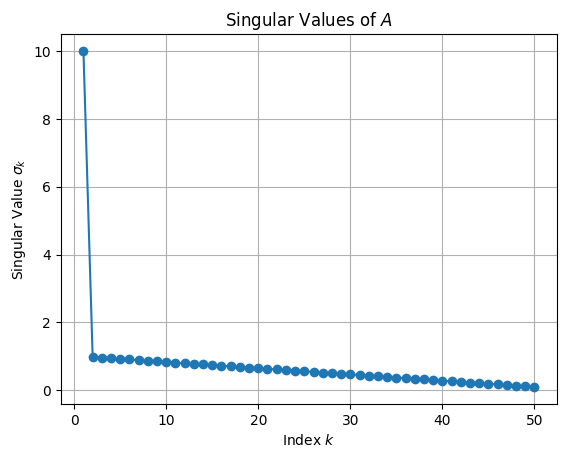

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Compute and plot singular values
singular_values = np.linalg.svd(A, compute_uv=False)

plt.figure()
plt.plot(np.arange(1, m+1), singular_values, marker='o')
plt.xlabel('Index $k$')
plt.ylabel('Singular Value $\\sigma_k$')
plt.title('Singular Values of $A$')
plt.grid(True)
plt.show()


### (B) Implementing the Power Method
Implement the power method on $A^TA∈R^{m×m}$ to estimate the top right singular vector.

#### 1. Write a function power_method(A, v0, num_iter) which:
-  Starts with an initial vector $v_0∈R^m$
- Iteratively computes $v_{k+1} = A^TAv_k$, and normalize the result
- Returns the iterates $v_k$ at each step

In [79]:
import numpy as np

def power_method(A: np.ndarray, v0: np.ndarray, num_iter: int):
    """
    Estimate the dominant right singular vector of A using the power method on A^T A.

    Parameters
    ----------
    A : array_like, shape (n, m)
        The input matrix.
    v0 : array_like, shape (m,)
        Initial guess for the right singular vector.
    num_iter : int
        Number of power‐method iterations to perform.

    Returns
    -------
    iterates : list of ndarray, length num_iter+1
        Sequence [v^(0), v^(1), …, v^(num_iter)], where each v^(k) is normalized.
    """
    # ensure numpy arrays
    A = np.asarray(A)
    v = np.asarray(v0, dtype=float)
    
    # normalize initial vector
    v /= np.linalg.norm(v)
    iterates = [v.copy()]
    
    for _ in range(num_iter):
        # apply AᵀA
        w = A.T @ (A @ v)
        # normalize
        v = w / np.linalg.norm(w)
        iterates.append(v.copy())
    
    return iterates


#### 2. Briefly explain our expectations for this algorithm’s outcomes.


We should see convergence to the top singular direction.
regardless of a “random” $v_0$ (so long as it isn’t orthogonal to the true $v_1$), the iterates $v^{(k)}$ rapidly align with the dominant right‐singular vector of $A$.
also, a geometric error decay which is the angle (or norm‐difference) to the true $v_1$ shrinks roughly by a factor of $\sigma_2/\sigma_1$ each iteration—so with a big gap we'll get fast convergence.
unless we start exactly perpendicular to $v_1$, different $v_0$ choices all end up at the same $v_1$; only the speed varies.


### (C) Initializations

#### 1. Generate two vectors that will be used for initialization:
- A random unit vector $v_{rand}∼N(0,I)$
- A vector $v_{orth}$ that is almost orthogonal to the main singular vector. Think about how to do this effectively.

In [80]:
import numpy as np

n, m = A.shape

# get the true top right singular vector v₁
_, _, Vt = np.linalg.svd(A, full_matrices=False)
v1 = Vt[0]                 # shape (m,)


# a random unit‐vector
vrand = np.random.randn(m)
vrand /= np.linalg.norm(vrand)

# an “almost” orthogonal vector (so it has a tiny component along v₁, not exactly zero)
# start with some random v
v_temp = np.random.randn(m)
v_temp /= np.linalg.norm(v_temp)

# project out the v₁–component → exact orthogonal
v_orth_exact = v_temp - np.dot(v_temp, v1) * v1
v_orth_exact /= np.linalg.norm(v_orth_exact)

# now add a small ε·v₁ so it’s not perfectly orthogonal
epsilon = 1e-3
vorth = v_orth_exact + epsilon * v1
vorth /= np.linalg.norm(vorth)

# check
print("dot(v1, vrand)  =", np.dot(v1, vrand))
print("dot(v1, vorth)  =", np.dot(v1, vorth))


dot(v1, vrand)  = -0.028914766615874193
dot(v1, vorth)  = 0.0009999995000003828


#### 2. Plot them on the same figure.

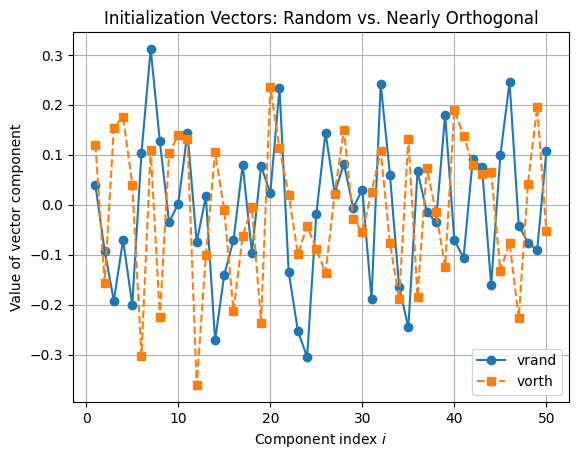

In [81]:
indices = np.arange(1, m+1)

plt.figure()
plt.plot(indices, vrand,  marker='o', linestyle='-', label='vrand')
plt.plot(indices, vorth, marker='s', linestyle='--', label='vorth')
plt.xlabel('Component index $i$')
plt.ylabel('Value of vector component')
plt.title('Initialization Vectors: Random vs. Nearly Orthogonal')
plt.legend()
plt.grid(True)
plt.show()

### (D) Measuring Convergence

#### 1. For each iterate $v_k$, compute the alignment with the true singular vector $v_1$ using the cosine distance: $$error_k = 1 −|⟨v_k,v_1⟩|$$

In [82]:
import numpy as np

def compute_errors(iterates, v1):
    """
    Given a list of normalized iterates [v⁽⁰⁾, v⁽¹⁾, …] and the true top singular vector v1,
    return the list of errors error_k = 1 - |⟨v⁽ᵏ⁾, v1⟩|.
    """
    return [1 - abs(np.dot(vk, v1)) for vk in iterates]

#### 2. Plot this error as a function of iteration $k$, for both initializations.

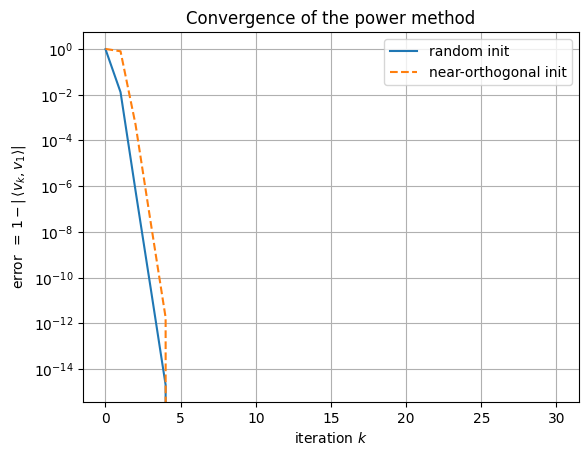

In [83]:
# --- parameters ---
num_iter = 30          # how many power-method steps to run

# --- run power method ---
iter_rand  = power_method(A, vrand,  num_iter)
iter_orth  = power_method(A, vorth,  num_iter)

# --- compute cosine-distance errors ---
err_rand = compute_errors(iter_rand, v1)
err_orth = compute_errors(iter_orth, v1)

# --- plot ---
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(err_rand,  label='random init')
plt.semilogy(err_orth,  label='near-orthogonal init', linestyle='--')
plt.xlabel('iteration $k$')
plt.ylabel(r'error $\,=\,1-|\,\langle v_k, v_1\rangle|$')
plt.title('Convergence of the power method')
plt.legend()
plt.grid(True, which='both')
plt.show()


#### 3. Observe how convergence differs between the random and orthogonal starts. Discuss the difference between them.

After the warm-up, the slope of both curves is identical; that slope is **σ₂ / σ₁ = 0.1** in our test matrix. The power method doesn’t care where we start—once we have *any* projection on the dominant singular direction, convergence speed is fixed by the gap.
Our orange vector started with a projection $ε = 10^{-3}$ on *$v_1$*.
Each iteration multiplies that component by σ₁=10 and all other components by $≤σ₂=1$. After
$$
   k_0=\Bigl\lceil\frac{\log(1/ε)}{\log(σ₁/σ₂)}\Bigr\rceil
   =\lceil\log_{10}(10^3)\rceil=1
$$

   step, the *v₁* part is already dominant and the curve merges with the blue one. That 1-iteration “delay” is exactly what the plot shows.

*Random starts converge fastest in practice*, because they almost never land exactly orthogonal. *Nearly-orthogonal starts* converge just as fast **after** a brief catch-up period whose length is logarithmic in 1/ε. In both cases, with a large singular-value gap the method reaches machine precision in only a handful of iterations.

#### 4. At each iteration $k$, compute the Rayleigh quotient: $$ρ_k = \|Av_k\|$$

In [84]:
# Compute Rayleigh quotients for both initializations
def compute_rayleigh_quotients(A, iterates):
    """
    Compute the Rayleigh quotient ρ_k = ‖Avk‖ for each iterate vk
    """
    return [np.linalg.norm(A @ vk) for vk in iterates]

rayleigh_rand = compute_rayleigh_quotients(A, iter_rand)
rayleigh_orth = compute_rayleigh_quotients(A, iter_orth)

#### 5. Plot $ρ_k$ as a function of $k$, and compare it to the top singular value $σ_1$. Explain your results.

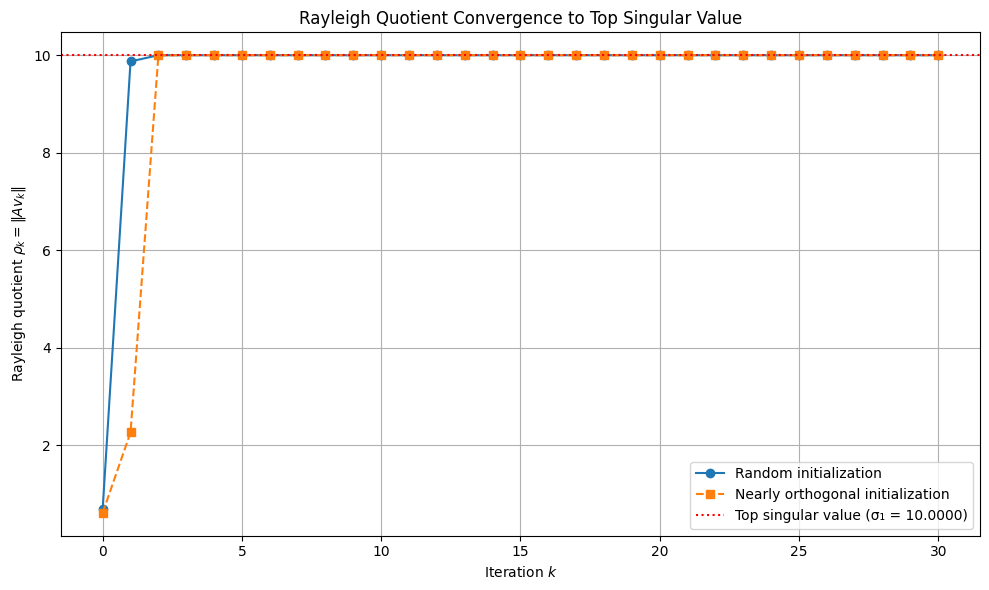

Top singular value (σ₁): 10.000000
Final Rayleigh quotient (random): 10.000000
Final Rayleigh quotient (orthogonal): 10.000000


In [85]:
# Get the top singular value for comparison
_, singular_values, _ = np.linalg.svd(A, full_matrices=False)
sigma1 = singular_values[0]

# Plot the Rayleigh quotients
plt.figure(figsize=(10, 6))
plt.plot(range(num_iter + 1), rayleigh_rand, 'o-', label='Random initialization')
plt.plot(range(num_iter + 1), rayleigh_orth, 's--', label='Nearly orthogonal initialization')
plt.axhline(y=sigma1, color='r', linestyle=':', label=f'Top singular value (σ₁ = {sigma1:.4f})')
plt.xlabel('Iteration $k$')
plt.ylabel('Rayleigh quotient $\\rho_k = \\|Av_k\\|$')
plt.title('Rayleigh Quotient Convergence to Top Singular Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the final values for comparison
print(f"Top singular value (σ₁): {sigma1:.6f}")
print(f"Final Rayleigh quotient (random): {rayleigh_rand[-1]:.6f}")
print(f"Final Rayleigh quotient (orthogonal): {rayleigh_orth[-1]:.6f}")

Both curves show that $\|Av_k\|$ (the Rayleigh quotient) climbs rapidly toward the top singular value $σ_1 = 10$: the random start reaches it in a single iteration, while the near-orthogonal start lags by one step before matching and then stays identical, confirming both iterates have locked onto the dominant singular direction.

## Q2

### Objective
In this question, you will use Principal Component Analysis (PCA) to explore the structure of facial
image data. You will visualize the principal components (also known as eigenfaces), reconstruct
images using different numbers of PCs, and interpret what information the leading components
capture.

### Dataset: Olivetti Faces
We use the Olivetti Faces dataset from the sklearn.datasets module. It consists of 400 grayscale
face images of size 64 ×64, each flattened into a 1D vector of length 4096. There are 40 unique
individuals, each with 10 different images.

In [86]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
X = faces.data # shape (400, 4096)
images = faces.images # shape (400, 64, 64)

### (A) PCA Decomposition

#### 1. Standardize the data (center it by subtracting the mean image).

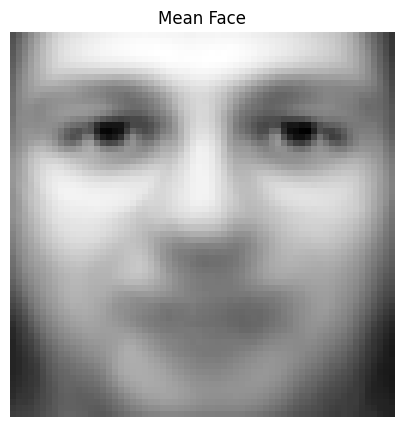

Original data shape: (400, 4096)
Centered data shape: (400, 4096)


In [87]:
# (A) PCA Decomposition
# 1. Standardize the data (center it by subtracting the mean image)
X_mean = np.mean(X, axis=0)  # Calculate the mean face
X_centered = X - X_mean  # Center the data

# Visualize the mean face
plt.figure(figsize=(5, 5))
plt.imshow(X_mean.reshape(64, 64), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

print(f"Original data shape: {X.shape}")
print(f"Centered data shape: {X_centered.shape}")

#### 2. Apply PCA and compute the first K = 100 components.

In [88]:
from sklearn.decomposition import PCA

# 2. Apply PCA and compute the first K = 100 components
K = 100
pca = PCA(n_components=K)
X_pca = pca.fit_transform(X_centered)  # Project data onto first K PCs
components = pca.components_  # Shape: (K, 4096) - These are the eigenfaces

# Print shapes and explained variance
print(f"Transformed data shape (X_pca): {X_pca.shape}")
print(f"Components (eigenfaces) shape: {components.shape}")
print(f"Total variance explained by first {K} components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

Transformed data shape (X_pca): (400, 100)
Components (eigenfaces) shape: (100, 4096)
Total variance explained by first 100 components: 93.49%


#### 3. Plot the cumulative explained variance ratio as a function of K.

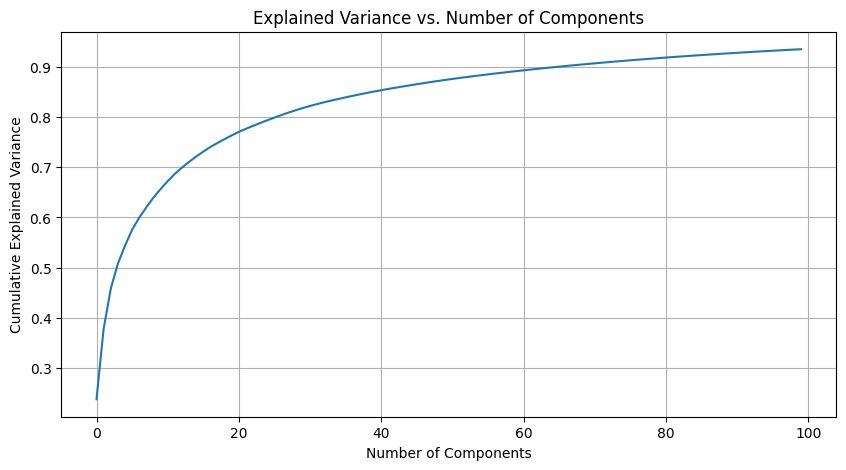

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### (B) Visualizing Eigenfaces

#### 1. Visualize the first 10 principal components as 64 ×64 grayscale images, as subplots.

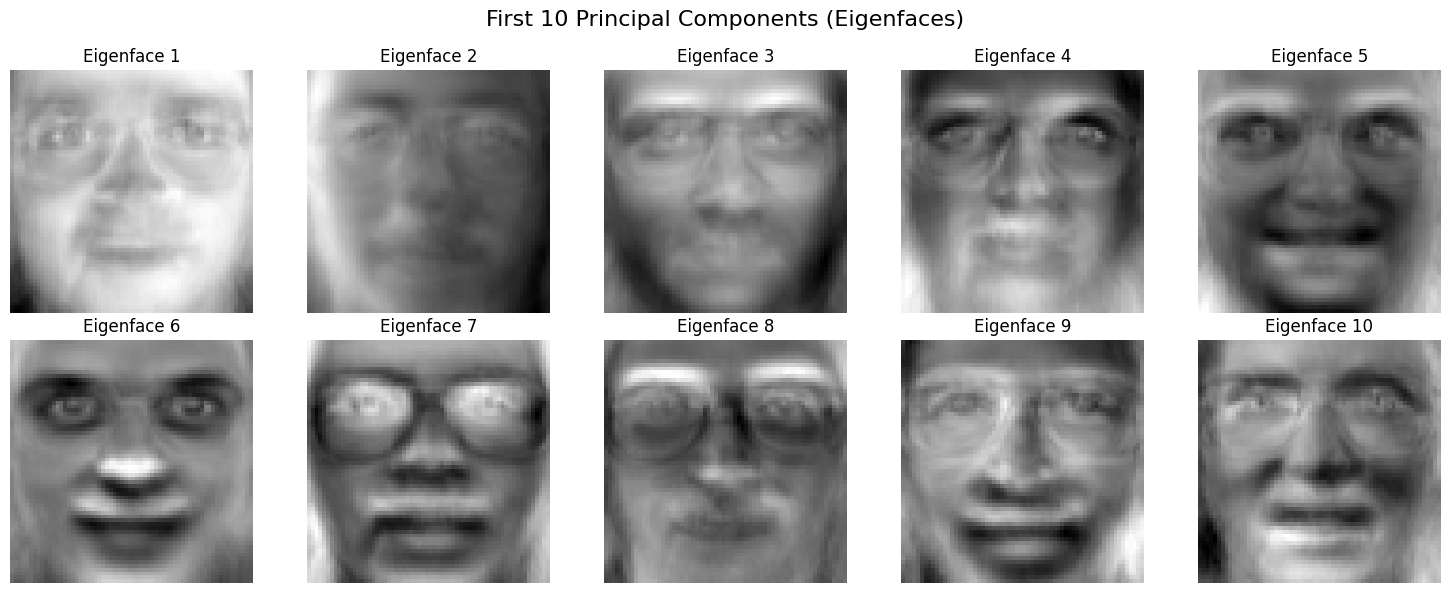

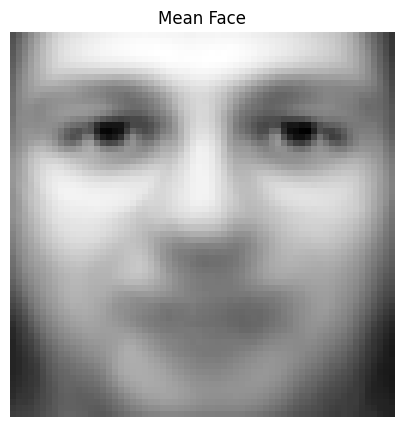

In [90]:
# (B) Visualizing Eigenfaces
# 1. Visualize the first 10 principal components as 64×64 grayscale images, as subplots

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Reshape the principal component (eigenface) back to 64×64
    eigenface = components[i].reshape(64, 64)
    
    # Calculate min and max for consistent scaling within each eigenface
    e_min, e_max = eigenface.min(), eigenface.max()
    
    # Plot the eigenface
    plt.imshow(eigenface, cmap='gray', vmin=e_min, vmax=e_max)
    plt.title(f'Eigenface {i+1}')
    plt.axis('off')

plt.suptitle('First 10 Principal Components (Eigenfaces)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

# Optional: Let's also visualize the mean face for comparison
plt.figure(figsize=(5, 5))
plt.imshow(X_mean.reshape(64, 64), cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

Looking at the first few eigenfaces, several key patterns of facial variation emerge from the dataset. The first eigenface primarily captures overall face structure and general lighting intensity across the entire face, providing a baseline representation. Eigenface 2 highlight side-to-side lighting variation, with distinct contrast between the left and right sides of the face. Eigenfaces 3-5 represent variations in facial expressions, particularly focused on the mouth region and subtle changes in expression. Head orientation and slight rotational variations are visible in some components, especially eigenface 4. Glasses appear prominently in several eigenfaces (particularly 7 and 8), indicating that the presence and style of eyewear is a significant source of variation in this dataset. The PCA effectively extracts these features in order of their contribution to overall variance, with more global features (lighting, face structure) appearing in earlier components and more specific attributes (glasses, specific expressions) in later ones.

### (C) Face Reconstruction

#### 1. Choose a few test images from the dataset (2-3).

In [91]:
# 1. Choose test images
test_indices = [10, 150, 300]  # Different individuals with varied characteristics
test_images = [images[idx] for idx in test_indices]
test_data = X[test_indices]
test_centered = X_centered[test_indices]

#### 2. Reconstruct them using different numbers of components (e.g., 5, 10, 25, 50, 100).

In [92]:
# 2. Reconstruct using different numbers of components
n_components_list = [5, 10, 25, 50, 100]
reconstructions = {}
reconstruction_errors = {}

for n_comp in n_components_list:
    # Project the test images onto the first n_comp components
    test_proj = np.dot(test_centered, components[:n_comp].T)
    
    # Reconstruct from the projections
    test_reconstructed = np.dot(test_proj, components[:n_comp]) + X_mean
    
    # Store reconstructions and compute reconstruction errors
    reconstructions[n_comp] = test_reconstructed
    
    # Mean squared error for each test image
    errors = np.mean((test_data - test_reconstructed) ** 2, axis=1)
    reconstruction_errors[n_comp] = errors


#### 3. For each reconstruction, compute and plot the reconstruction error.

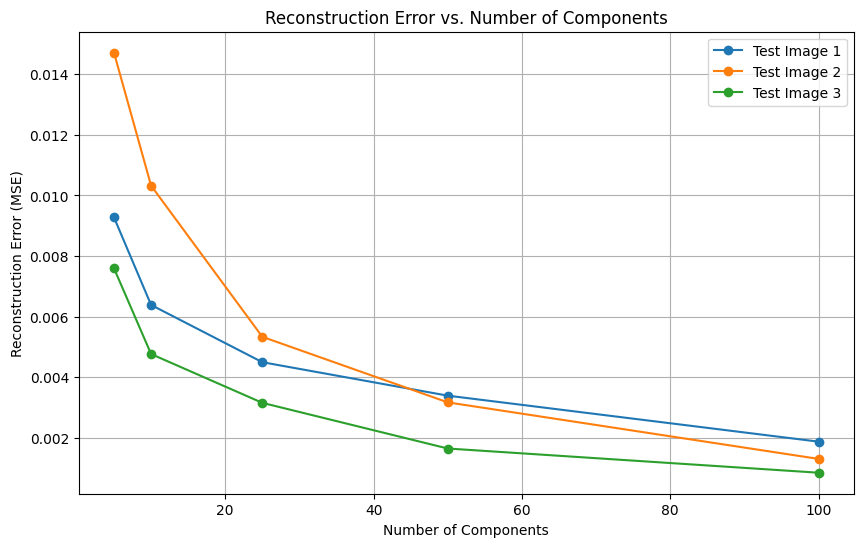

In [93]:
# 3. Plot reconstruction errors
plt.figure(figsize=(10, 6))
for i, idx in enumerate(test_indices):
    errors = [reconstruction_errors[n_comp][i] for n_comp in n_components_list]
    plt.plot(n_components_list, errors, marker='o', label=f'Test Image {i+1}')

plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()

#### 4. Visualize the original vs. reconstructed images side-by-side (again, use subplots for that).

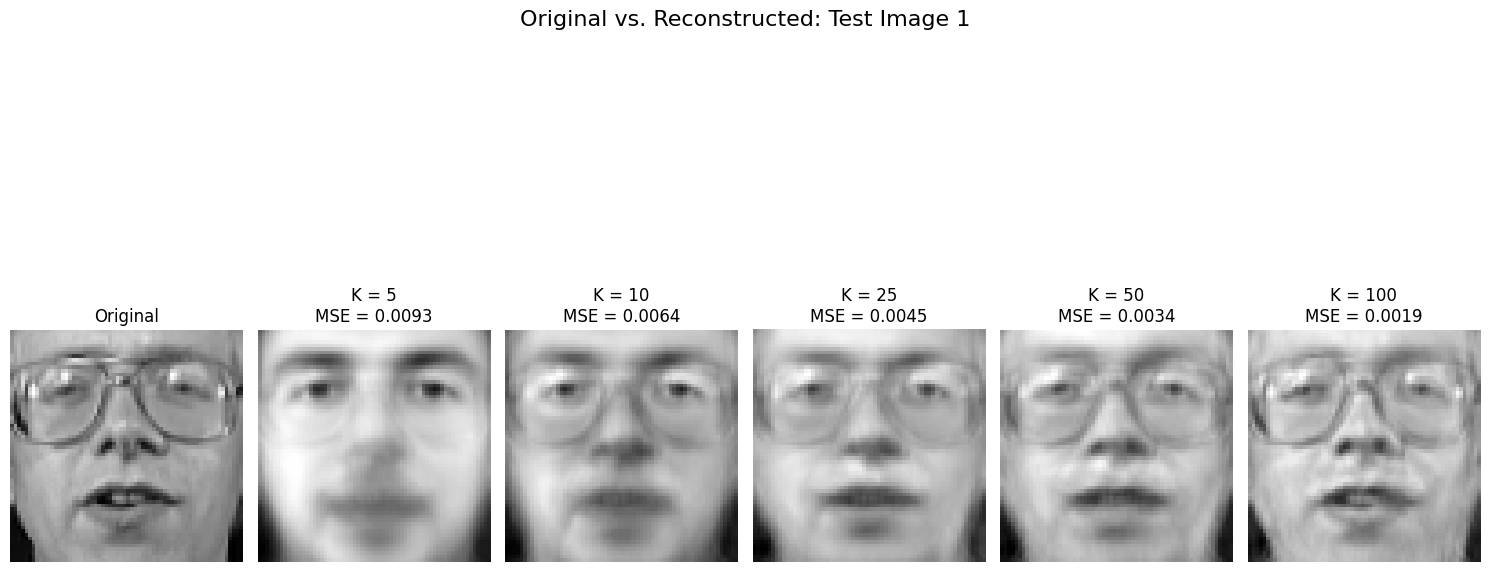

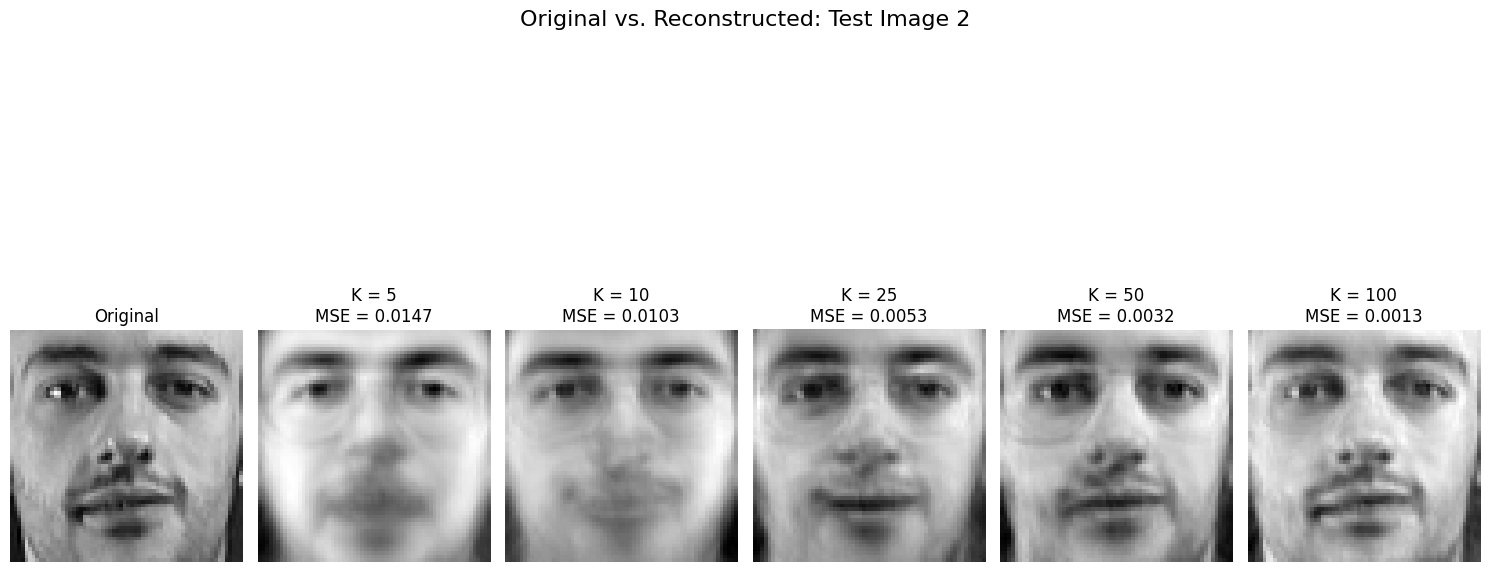

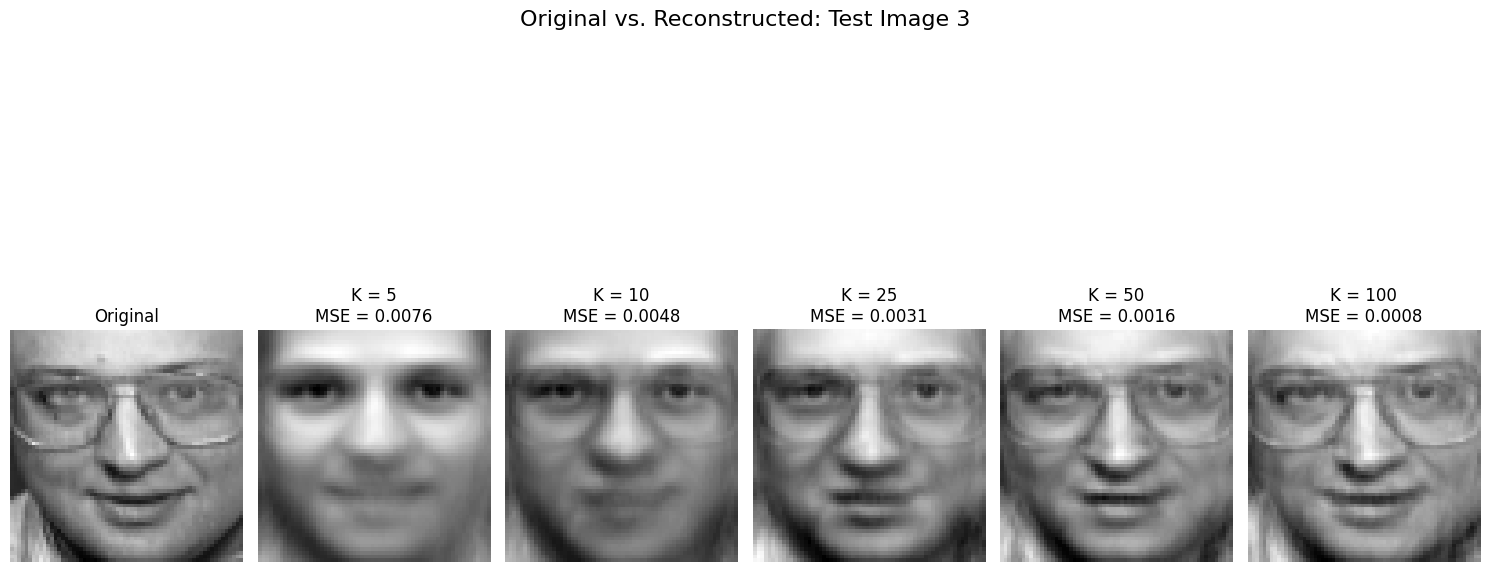

In [94]:
# 4. Visualize original vs. reconstructed images
for i, idx in enumerate(test_indices):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, len(n_components_list) + 1, 1)
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f'Original')
    plt.axis('off')
    
    for j, n_comp in enumerate(n_components_list):
        plt.subplot(1, len(n_components_list) + 1, j + 2)
        recon_img = reconstructions[n_comp][i].reshape(64, 64)
        plt.imshow(recon_img, cmap='gray')
        plt.title(f'K = {n_comp}\nMSE = {reconstruction_errors[n_comp][i]:.4f}')
        plt.axis('off')
    
    plt.suptitle(f'Original vs. Reconstructed: Test Image {i+1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()